<a href="https://colab.research.google.com/github/saadz-khan/Text2Image/blob/master/pixray_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

follow me on twitter: [@dazhizhong](https://twitter.com/DazhiZhong) and find me on [Github](https://github.com/dazhiZhong)

# setup

In [1]:
#@title Installing/Setup { vertical-output: true }
!pip3 install opencv-python==4.2.0.32
!pip3 install vispy==0.6.4
!pip3 install moviepy==1.0.2
!pip3 install transforms3d==0.3.1
!pip3 install networkx==2.3
!sudo apt install sed
!git clone https://github.com/dazhizhong/3d-photo-inpainting.git
%cd 3d-photo-inpainting
!git checkout 20361ff
!sh download.sh
!sed -i 's/offscreen_rendering: True/offscreen_rendering: False/g' argument.yml
%cd ..
!rm -rf pixray
!git clone  https://github.com/pixray/pixray.git
!cd pixray && git checkout de99b86
!pip install -r pixray/requirements.txt
!pip uninstall -y tensorflow 
!git clone https://github.com/pixray/diffvg
%cd diffvg
!git checkout c40ec08
!git submodule update --init --recursive
!python setup.py install
%cd ..
!pip freeze | grep torch
!mkdir models
exit()

     |████████████████████████████████| 28.2 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 2.3 MB 8.8 MB/s 
     |████████████████████████████████| 890 kB 48.0 MB/s 
     |████████████████████████████████| 7.8 MB 6.2 MB/s 
     |████████████████████████████████| 3.3 MB 54.5 MB/s 
     |████████████████████████████████| 26.9 MB 1.2 MB/s 
     |████████████████████████████████| 4.3 MB 53.8 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.2-py3-none-any.whl size=110744 sha256=6b5bcde367eccb6da17b44c8235b88d544c63e712e

     |████████████████████████████████| 62 kB 1.4 MB/s 
  Created wheel for transforms3d: filename=transforms3d-0.3.1-py3-none-any.whl size=59373 sha256=26933d02aa6eeba92b083d08f2b1398a193e4de4d2f6d00e2758424fd535013e
  Stored in directory: /root/.cache/pip/wheels/b5/b7/93/8985551f83720ce37548a5b543c75380bb707955a9c2c5d28c
Successfully built transforms3d
     |████████████████████████████████| 1.7 MB 9.9 MB/s 
  Created wheel for networkx: filename=networkx-2.3-py2.py3-none-any.whl size=1556008 sha256=8c62a18b9ffc9886997853f9dedd370d0fd6639acc0d3165e9c6accd5ccbe401
  Stored in directory: /root/.cache/pip/wheels/44/e6/b8/4efaab31158e9e9ca9ed80b11f6b11130bac9a9672b3cbbeaf
Successfully built networkx
  Attempting uninstall: networkx
    Found existing installation: networkx 2.6.3
    Uninstalling networkx-2.6.3:
      Successfully uninstalled networkx-2.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the sour

Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
Cloning into 'diffvg'...
remote: Enumerating objects: 283, done.
remote: Total 283 (delta 0), reused 0 (delta 0), pack-reused 283
Receiving objects: 100% (283/283), 10.27 MiB | 12.17 MiB/s, done.
Resolving deltas: 100% (107/107), done.
/content/diffvg
Note: checking out 'c40ec08'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at c40ec08 Merge pull request #2 from DazhiZhong/bugfix
Submodule 'pybind11' (https://github.com/pybind/pybind11.git) registered for path 'pybind11'
Submodule 'thrust' (https://gith

# main

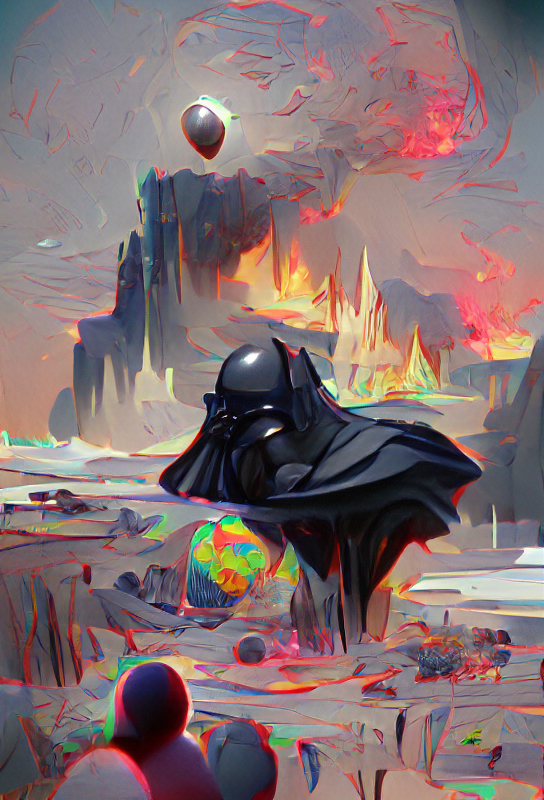

iter: 200, finished (-2=>5.682)

Generating video...


In [18]:
#@title Generate image from prompt { vertical-output: true }
import sys
import regex as re
import os
sys.path.append("pixray")
import pixray

punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

prompts = "Dark Vader watches the implosion of a planet | fantasy art trending on artstation" #@param {type:"string"}
drawer = "vqgan"

no_punct = ""
for char in prompts:
   if char not in punctuations:
       no_punct = no_punct + char

init_image = "Path or URL of the image works"#@param {type:"string"}
init_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)
#init_image = re.findall('^/[\w\.\-]+$', init_image)

if not init_image:
  init_image = None


video = True #@param {type:"boolean"}

display_clear = True #@param {type:"boolean"}

pixel_scale = 0.75 #@param {type:"slider", min:0.25, max:2.0, step:0.25}

quality = 'supreme' #@param ["normal", "better", "best", "supreme"]

optimiser = 'Adam' #@param ["Adam", "DiffGrad"]

palette = True #@param {type:"boolean"}
if palette:
  use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}

print(init_image)

#@markdown When you have the settings you want, press the play button on the left.
#@markdown The system will save these and start generating images below.
#@markdown When that is done you can change these
#@markdown settings and see if you get different results. Or if you get
#@markdown impatient, just select "Runtime -> Interrupt Execution".
#@markdown Note that the first time you run it may take a bit longer
#@markdown as nessary files are downloaded.
#@markdown
#@markdown *Advanced: you can also edit this cell and add additional
#@markdown settings, combining settings from different notebooks.*

# these are good settings for pixeldraw
pixray.reset_settings()
pixray.add_settings(prompts=prompts)
pixray.add_settings(quality="supreme",
                    size=[544,800],
                    iterations=200,
                    drawer=drawer,
                    display_clear=display_clear,
                    make_video=video,
                    scale = 2,
                    optimiser = optimiser,
                    init_image = init_image)

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)

os.rename('output.png', f'{no_punct}.png')
!rm -rf ./output.png
if video:
  os.rename('output.mp4', f'{no_punct}.mp4')
  !rm -rf ./output.mp4

In [ ]:
import torch
torch.cuda.empty_cache()

import shutil
# shutil.copy("output.png","3d-photo-inpainting/image")

from PIL import Image
import os
import glob
for f in glob.glob("3d-photo-inpainting/image/*.*"):
    os.remove(f)
im = Image.open(settings.output)
im.save(f"3d-photo-inpainting/image/input.jpg")


import time
begin = time.time()
for f in glob.glob("3d-photo-inpainting/video/*.*"):
    os.remove(f)
%cd 3d-photo-inpainting 
!python main.py --config argument.yml
%cd ..
print(f"finished in {time.time() - begin}")


from IPython import display
import glob
from PIL import Image
from IPython.display import HTML
from base64 import b64encode
from IPython.utils import io

fps = glob.glob("3d-photo-inpainting/video/*")
for f in fps:
    mp4 = open(f,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    # display.clear_output()
    display.display(HTML("""
    <video height=350 controls loop autoplay>
        <source src="%s" type="video/mp4">
    </video>
    """ % data_url))